# 서울시 공공도서관 데이터 분석
### 세부 분석 내용
- 인구 대비 공공도서관 수 분석
- 인구 대비 공공도서관 평균치 확인하고 도서관 수가 상대적으로 부족한 구 확인
- 공공도서관 연면적 관련 상관 분석
- 최근 8년 간 공공도서관 방문객 수 증감 분석
- 공공도서관 총자료수, 연간 방문자수 부분 회귀 분석
- 공공도서관 총예산, 총자료수, 연간 방문자수 상관 분석
- 연령별 관심 분야 분석
- 대출권수 상관 분석

### 사용한 데이터
- 공공데이터포털 행정안전부_지역별(시도/시군구/읍면동) 주민등록 세대현황 https://www.data.go.kr/data/3033295/fileData.do
- 국가도서관통계시스템 https://www.libsta.go.kr/statistics/public/stat

# 필요 라이브러리 가져오기, 기본 설정 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mat
import numpy as np
from statsmodels.formula.api import ols,glm
import statsmodels.api as sm
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore') # 경고문구 없애기 위해 사용
%matplotlib inline

import json
import folium

# 폰트 설정
import platform # 운영체제에서 폰트를 건드리기 위해서 import 함
from matplotlib import font_manager, rc # 운영체제에서 폰트를 확인
plt.rcParams['axes.unicode_minus'] = False # 음수 처리
if platform.system() == 'Darwin':
 rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
 path = "c:/Windows/Fonts/malgun.ttf"
# 폰트명을 확인하고 싶으면 폰트의 속성을 확인
 font_name = font_manager.FontProperties(fname=path).get_name()
 rc('font', family=font_name)
else:
 print('Unknown system... sorry~~~~')

ModuleNotFoundError: No module named 'folium'

# 1. 인구 대비 공공도서관 분석

## 구별 도서관 수 데이터 가져오기

In [181]:
df = pd.read_excel('2020년_도서관별통계입력데이터_공공도서관.xlsx',index_col='번호')
filt = df['지역'].str.contains('서울') #서울 지역만 필터링
df = df[filt]
num = list(df['시군구'].value_counts()) #value_counts함수를 통해 도서관이 속해있는 '시군구'열에서 구의 개수를 세서 num에 저장

# 구 목록을 리스트에 저장(unique함수를 통해 중복 제거)
gu_list = list(df['시군구'].unique())

# 시군구, 도서관_수를 column으로 가지는 df2 데이터 프레임 : 
df2 = pd.DataFrame({'시군구' : gu_list, '도서관_수' : num})
df2.sort_values('시군구', inplace =True)  # 시군구 열을 기준으로 데이터프레임 정렬
df2.reset_index(drop=True, inplace=True) # 인덱스 리셋

df2.head()

,시군구,도서관_수
0,강남구,11
1,강동구,9
2,강북구,9
3,강서구,9
4,관악구,7


## 구별 인구수 데이터 가져오기

In [182]:
# '2020년도 서울시 구별 인구수' 데이터 읽기
ingu_df = pd.read_csv('seoul_ingu.csv', encoding='cp949')
ingu_df.sort_values('행정구역', inplace = True)
ingu_df.drop(index=0, inplace = True) # 필요하지 않은 행 삭제
i = ingu_df[['2020년_총인구수','행정구역']]

# 인덱스 리셋
i.reset_index(drop = True, inplace = True)
i.head()

,2020년_총인구수,행정구역
0,539231,서울특별시 강남구 (1168000000)
1,459970,서울특별시 강동구 (1174000000)
2,308055,서울특별시 강북구 (1130500000)
3,580185,서울특별시 강서구 (1150000000)
4,495060,서울특별시 관악구 (1162000000)


## 구별 도서관수, 인구수 데이터 프레임 만들기

In [183]:
# df2에 '인구수', '행정구역 열' 추가
df2[['인구수','행정구역']] = i[['2020년_총인구수','행정구역']]

# 인구 대비 도서관 수
# 수치가 높을수록 인구에 비해 도서관이 없음을 의미하고
# 수치가 낮을수록 인구에 비해 도서관이 많음을 의미합니다.
df2['도서관수/인구수'] = (df2['도서관_수'].div(df2['인구수']))
df2.head()

,시군구,도서관_수,인구수,행정구역,도서관수/인구수
0,강남구,11,539231,서울특별시 강남구 (1168000000),0.000020
1,강동구,9,459970,서울특별시 강동구 (1174000000),0.000020
2,강북구,9,308055,서울특별시 강북구 (1130500000),0.000029
3,강서구,9,580185,서울특별시 강서구 (1150000000),0.000016
4,관악구,7,495060,서울특별시 관악구 (1162000000),0.000014


## json, folium을 사용하여 시각화
- https://github.com/southkorea/seoul-maps/tree/master/juso/2015/json

In [184]:
geo_path = 'seoul_municipalities_geo.json' # geojson 파일 주소
geo_str = json.load(open(geo_path, encoding = "utf-8")) #파일 읽기

map = folium.Map(location = [37.528850, 126.984085], zoom_start = 11,width=640,height=450)# location 을 기준으로 맵 생성

# geojson파일을 사용하여 서울시를 구별로 나눌 수 있었습니다.
# 인구수/도서관수 수치를 기반으로 
# 1관당 인구수가 많으면 진한색으로, 1관당 인구수가 적으면 연한색으로 해당 구를 색칠하도록 했습니다.
folium.Choropleth(
    geo_data = geo_str,# 지도 정보
    data = df2, # 지도에 나타낼 데이터
    columns = ['시군구', '도서관수/인구수'],# geo데이터의 시군구 정보와 매핑 할 df2의 '시군구' column, 인구수/도서관수를 value값으로
    fill_color = 'YlOrBr',
    key_on = 'feature.properties.SIG_KOR_NM',# json에서 매핑할 키(시군구 이름), 키에 해당하는 value는 구에 해당하는 좌표들
    legend_name = '인구 대비 도서관 수'
).add_to(map)

map

## 인구 대비 도서관수 평균치 확인

In [185]:
fp1 = np.polyfit(df2['인구수'],df2['도서관_수'],1) 
# 회귀직선을 구함
# polyfit은 최소차수를 사용해서 절편과 기울기를 구함
# 세번째 인자는 나타낼 차수를 의미

fp1 = np.polyfit(df2['인구수'],df2['도서관_수'],1)
f1 = np.poly1d(fp1)
fx = np.linspace(100000,700000,100)

df2['오차'] = np.abs(df2['도서관_수'] - f1(df2['인구수']))

df_sort = df2.sort_values(by = '오차',ascending = False)
df_sort=df_sort.reset_index(drop=True)
df_sort.head()

,시군구,도서관_수,인구수,행정구역,도서관수/인구수,오차
0,종로구,14,149384,서울특별시 종로구 (1111000000),0.000094,7.212587
1,중구,12,125240,서울특별시 중구 (1114000000),0.000096,5.287107
2,송파구,13,667960,서울특별시 송파구 (1171000000),0.000019,4.612019
3,중랑구,4,394702,서울특별시 중랑구 (1126000000),0.000010,3.544579
4,양천구,11,454251,서울특별시 양천구 (1147000000),0.000024,3.271625


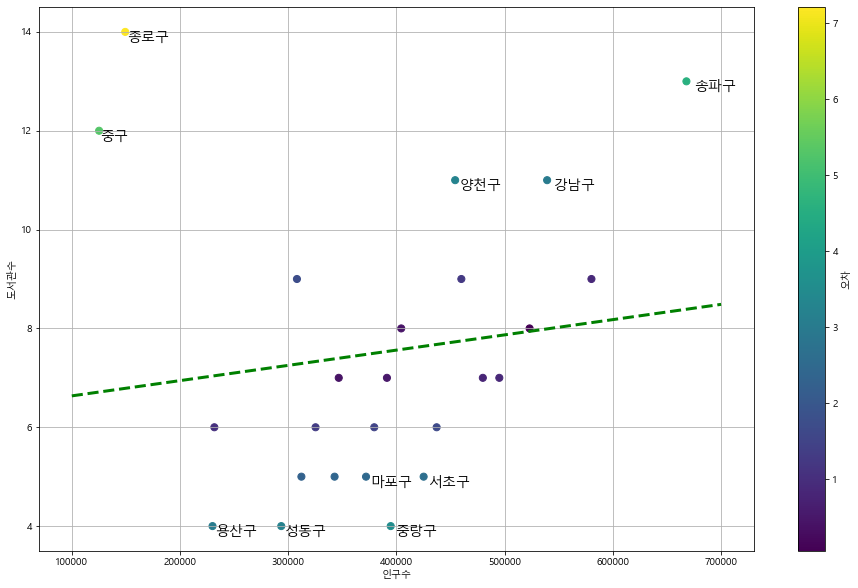

In [186]:
plt.figure(figsize=(16,10))
plt.scatter(df2['인구수'], df2['도서관_수'], c=df2['오차'], s=50)

plt.plot(fx, f1(fx), ls='dashed', lw=3, color='g')

# 오차가 큰 상위 10개에 구 이름 표시
for n in range(10):
    plt.text(df_sort['인구수'][n]*1.01, df_sort['도서관_수'][n]-0.2, df_sort['시군구'][n], fontsize=14)
plt.xlabel('인구수')
plt.ylabel('도서관수')
plt.colorbar(label='오차')

plt.grid()
plt.show()
plt.close()

# 2. 공공도서관 연면적 관련 상관 분석
- 연면적: 건물 모든 층의 면적을 합한 넓이

## 연면적과 관련있을것 같은 column 추출

In [187]:
df = pd.read_excel('2020년_도서관별통계입력데이터_공공도서관.xlsx',index_col='번호')
df = df[['시설_연면적','좌석_총좌석수', '직원_정규직_사서정원',
    '직원_정규직_행정정원','직원_정규직_전산정원','직원_정규직_기타정원',
    '합계_전문교육_시간','합계_일반교육_시간','결산_운영비_금액(천원)','연간_총_개관일수',
    '주당_평균_개관시간','회원등록자수_어린이','회원등록자수_청소년','회원등록자수_성인',
    '도서관_방문자수','홈페이지_접속건수','모바일웹_접속건수','장애인용_인쇄자료','장애인용_비도서자료','메타데이터_도서자료',
    '메타데이터_비도서'
   ]]
df['직원_정원_합계'] = df['직원_정규직_사서정원'] + df['직원_정규직_행정정원'] + df['직원_정규직_전산정원'] + df['직원_정규직_기타정원']
df.drop(columns = ['직원_정규직_사서정원','직원_정규직_행정정원','직원_정규직_전산정원','직원_정규직_기타정원'], inplace = True)
df['직원_교육_시간_합계'] = df['합계_전문교육_시간'] + df['합계_일반교육_시간']
df.drop(columns = ['합계_전문교육_시간','합계_일반교육_시간'], inplace = True)
df['회원등록자수_합계'] = df['회원등록자수_어린이'] + df['회원등록자수_청소년'] + df['회원등록자수_성인']
df.drop(columns = ['회원등록자수_어린이','회원등록자수_청소년','회원등록자수_성인'], inplace = True)
df['장애인용_자료_합계'] = df['장애인용_인쇄자료'] + df['장애인용_비도서자료']
df.drop(columns = ['장애인용_인쇄자료','장애인용_비도서자료'], inplace = True)
df.columns = ['시설_연면적', '좌석_총좌석수', '결산_운영비_금액', '연간_총_개관일수', '주당_평균_개관시간',
       '도서관_방문자수', '홈페이지_접속건수', '모바일웹_접속건수', '도서자료_총합', '비도서자료_총합',
       '직원_정원_합계', '직원_교육_시간_합계', '회원등록자수_합계', '장애인용_자료_합계']
df

,시설_연면적,좌석_총좌석수,결산_운영비_금액,연간_총_개관일수,주당_평균_개관시간,도서관_방문자수,홈페이지_접속건수,모바일웹_접속건수,도서자료_총합,비도서자료_총합,직원_정원_합계,직원_교육_시간_합계,회원등록자수_합계,장애인용_자료_합계
번호,,,,,,,,,,,,,,
1,2847.98,107,218071,64,44,18217,49117,24559,52428,1806,9.0,30,137,188
2,7301.21,137,996025,53,41,901,330,34548,0,0,18.0,0,51,0
3,805.71,100,21960,137,52,18966,1316612,31652,29397,0,4.0,64,6182,113
4,2103.00,136,650688,173,54,69013,232893,0,49125,9578,7.0,334,5883,388
5,3877.00,582,447084,178,41,110505,47518,47519,148982,3327,8.0,387,441402,465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,3948.00,134,98974,200,86,50389,49040,17640,64271,1983,7.0,52,7329,472
1169,1453.58,327,62909,179,54,53365,46035,46034,48473,0,7.0,615,14097,463
1170,305.84,86,137491,127,54,26919,105852,13891,30311,1882,4.0,602,2329,22


## 피어슨 계수를 이용한 상관 분석

In [188]:
# 상관 분석
corr_df = df.corr(method = 'pearson')
# 피어슨 계수가 0.7이상인 것만 표시
corr_df[corr_df[:] > 0.7]

,시설_연면적,좌석_총좌석수,결산_운영비_금액,연간_총_개관일수,주당_평균_개관시간,도서관_방문자수,홈페이지_접속건수,모바일웹_접속건수,도서자료_총합,비도서자료_총합,직원_정원_합계,직원_교육_시간_합계,회원등록자수_합계,장애인용_자료_합계
시설_연면적,1.000000,0.777452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.736459,NaN,NaN,NaN
좌석_총좌석수,0.777452,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
결산_운영비_금액,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
연간_총_개관일수,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
주당_평균_개관시간,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
도서관_방문자수,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
홈페이지_접속건수,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
모바일웹_접속건수,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
도서자료_총합,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
비도서자료_총합,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


## seaborn을 사용한 상관관계 시각화

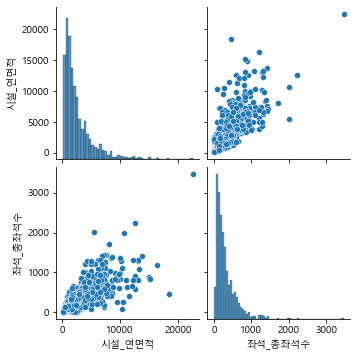

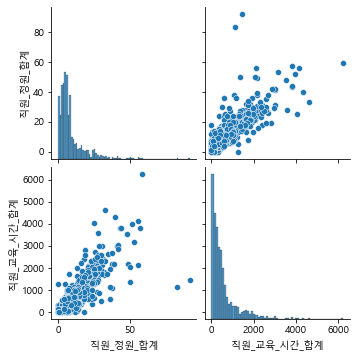

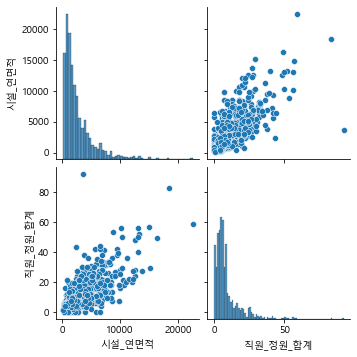

In [189]:
# 연면적과 좌석수 상관관계 시각화
# 피어슨 계수 0.777452
sns.pairplot(df,vars=['시설_연면적', '좌석_총좌석수'])
plt.rc('font', family='Malgun Gothic')
plt.show()

# 직원합계와 교육시간 상관관계 시각화
# 피어슨 계수 0.830352
sns.pairplot(df,vars=['직원_정원_합계', '직원_교육_시간_합계'])
plt.rc('font', family='Malgun Gothic')
plt.show()

# 면적과 직원합계 상관관계 시각화
# 피어슨 계수 0.736459
sns.pairplot(df,vars=['시설_연면적', '직원_정원_합계'])
plt.rc('font', family='Malgun Gothic')
plt.show()
plt.close()

# 3. 최근 8년 간 공공도서관 별 방문객 수 증감 분석

## 데이터 가져오기

In [3]:
#데이터 불러오기
df = pd.read_excel('공공도서관 통계데이터.xlsx').drop([0,1,2]).fillna(0) 

df['지역'] = df['지역'].str.replace('서울 ','').str.strip()
df.head()

,지역,도서관명,2014,2015,2016,2017,2018,2019,2020,2021
3,관악구,성현동작은도서관,58893,62081,50572,47895,48857,50403,7935,12244
4,양천구,신월음악도서관,162957,23000,425163,270707,255986,262515,79785,131170
5,관악구,글빛정보도서관,230723,247470,252019,284474,245433,201410,30259,36218
6,동대문구,동대문구정보화도서관,1101779,1440295,816509,558288,936563,857129,341547,272594
7,노원구,노원중앙도서관,2372497,2024010,1537522,1487199,1367458,808951,265284,499845


## 원하는 구 입력받고 방문자 수 증감 퍼센트 시각화

서울의 구 이름을 입력하시오: 강남구


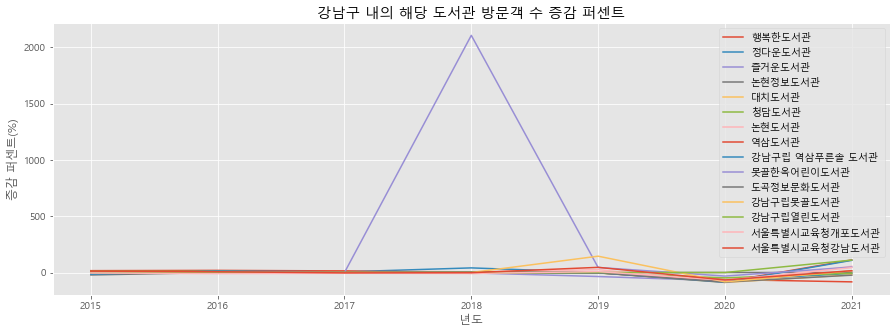

In [194]:
#데이터 타입 변환
for i in range(2014, 2022): 
    df[i]=df[i].astype(dtype='int64')

#원하는 구 이름 입력받기
name=input("서울의 구 이름을 입력하시오: ")

#입력받은 구 데이터 슬라이싱
df=df.loc[df['지역']==name] 

#인덱스 초기화
df.reset_index(drop=True, inplace=True)

#결측값 채우기 과정
df = df.transpose() 
df = df.replace(0, np.NaN)
df = df.fillna(method='bfill')
df = df.fillna(method='ffill')
df = df.transpose()

#해당 년도 방문자 수 증감 퍼센트 
for i in range (2015, 2022): 
    df[i+10]=(df[i]-df[i-1])/df[i-1]*100
    
#컬럼 이름 재정비
for i in range(2014, 2022): 
    del df[i] 
    df = df.rename(columns = {i+10:i}) 
df=df.transpose() 
library_list = df.iloc[1] 
library_list= library_list.tolist()

df2=df.iloc[2:]

df2_count=len(df2.columns)
df2.reset_index(drop=False, inplace=True)

#그래프 출력
plt.style.use('ggplot') 
plt.figure(figsize=(15,5)) 
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False) 

##for문을 통해 그래프를 중첩하여 출력
for i in range(0, df2_count): 
    plt.plot(df2['index'], df2[i], label = library_list[i]) 
plt.title(name + ' 내의 해당 도서관 방문객 수 증감 퍼센트') 
plt.xlabel('년도')
plt.ylabel('증감 퍼센트(%)') 
plt.legend() 
plt.show()
plt.close()

# 4. 서울시 공공도서관 총 자료수와 연간 방문자 수 상관 분석

## 데이터 가져오기

In [195]:
df = pd.read_excel('2020년_도서관별통계입력데이터_공공도서관.xlsx',index_col='도서관명')

filt = df['지역'].str.contains('서울') 
df = df[filt]

# 도서_국내_총류 ~ 연속간행물_국외 까지의 column을 find 데이터프레임으로 추출
find = df.iloc[:,[34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63]] 
find['총자료수'] = np.sum(find, axis=1)
find['연간_방문자수'] = df['도서관_방문자수']
find['시군구'] = df['시군구']
find = find[['시군구', '총자료수', '연간_방문자수']]
find.head()

,시군구,총자료수,연간_방문자수
도서관명,,,
4.19 혁명기념 도서관,종로구,62939,901
가락몰도서관,송파구,33787,18966
가온도서관,중구,74460,64416
갈산도서관,양천구,54280,77625
강남구립 역삼푸른솔 도서관,강남구,62901,31035


## 서울시 모든 구 도서관의 총자료수와 연간 방문자수의 상관관계를 산점도로 시각화

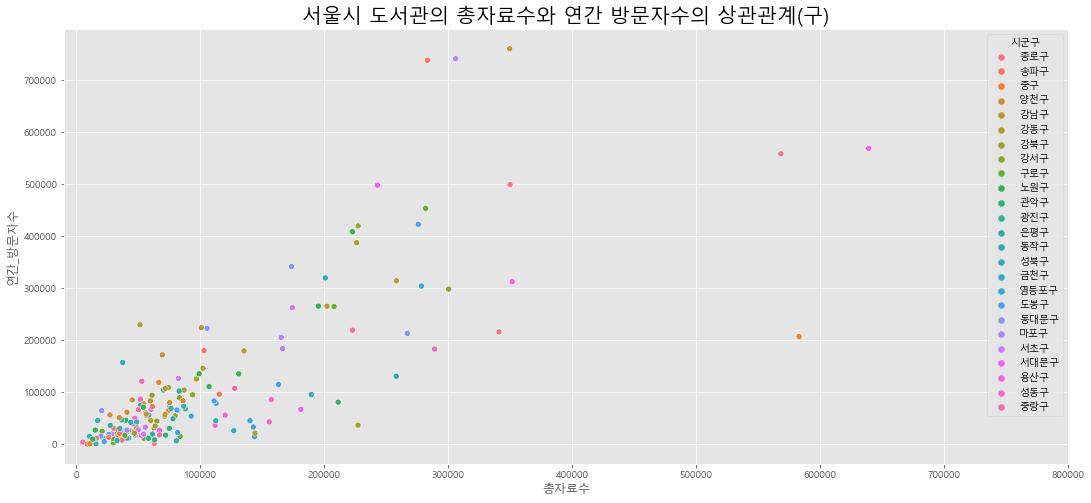

In [196]:
# 그래프 사이즈 설정(figsize), 산점도 출력. x축:총자료수, y축:연간 방문자수, hue: 구
f, ax = plt.subplots(1,1,figsize=(18,8))
sns.scatterplot(data = find, x="총자료수", y="연간_방문자수", hue = "시군구")

# x축 범위 조정
ax.set_xlim(-10000, 800000)
ax.set_title("서울시 도서관의 총자료수와 연간 방문자수의 상관관계(구)", size = 20)
plt.rcParams['font.family'] = 'NanumGothic'
plt.show()
plt.close()

# 5. 서울시 공공도서관의 총자료수와 연간 방문자수의 상관관계를 부분회귀분석

## 데이터 가져오기

In [197]:
df = pd.read_excel('2020년_도서관별통계입력데이터_공공도서관.xlsx',index_col='도서관명')
filt = df['지역'].str.contains('서울') 
df = df[filt]

# 도서_국내_총류 ~ 도서_국내_역사 까지의 column을 find 데이터프레임으로 추출
find = df.iloc[:,[34,35,36,37,38,39,40,41,42,43]] 
find

,도서_국내_총류,도서_국내_철학,도서_국내_종교,도서_국내_사회과학,도서_국내_순수과학,도서_국내_기술과학,도서_국내_예술,도서_국내_언어,도서_국내_문학,도서_국내_역사
도서관명,,,,,,,,,,
4.19 혁명기념 도서관,4579,2453,1398,11324,2305,4126,2481,2117,14948,15790
가락몰도서관,1041,1319,405,4838,1548,3835,799,354,12572,2066
가온도서관,2045,3701,1574,10616,4759,4451,3166,1684,26313,5841
갈산도서관,1759,2181,622,7303,4494,3040,1469,815,18854,3102
강남구립 역삼푸른솔 도서관,1567,1926,1037,4962,3142,2280,1536,948,15196,2838
...,...,...,...,...,...,...,...,...,...,...
해오름도서관,1146,1140,388,5226,4019,1887,950,620,19111,3547
행복한도서관,1904,2865,1109,5726,3574,2856,1904,1137,18217,4145
향기나무도서관,516,894,84,1757,1235,1209,2276,138,4040,924


## 부분 회귀 분석 시각화

eval_env: 1


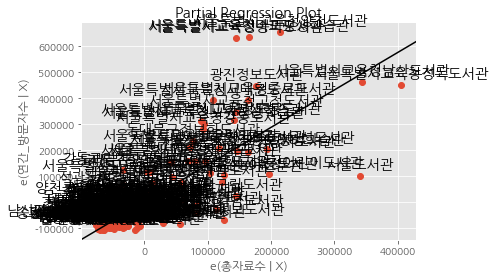

<Figure size 1296x576 with 0 Axes>

In [198]:
find['총자료수'] = np.sum(find, axis=1)
find['연간_방문자수'] = df['도서관_방문자수']
find = find[['총자료수', '연간_방문자수']]
# 종속변수: 연간_방문자수, 독립변수: 총자료수
res = ols('연간_방문자수~총자료수', data=find).fit()

# 총자료수가 연간방문자 수에 미치는 영향력을 분석.
others = list(set(find.columns).difference(set(["연간_방문자수","총자료수"])))
p, resids = sm.graphics.plot_partregress("연간_방문자수","총자료수",others, data=find, ret_coords = True)
fig = plt.figure(figsize=(18,8))

plt.rc('font', size=10, family='Malgun Gothic')
plt.show()
plt.close()

## 부분 회귀 분석 시각화(도서관 이름 제거)

eval_env: 1


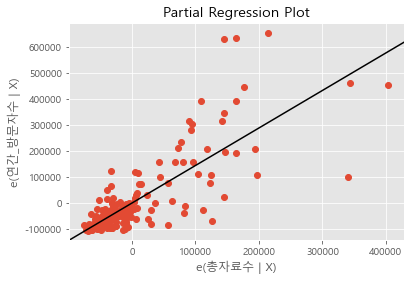

<Figure size 1296x576 with 0 Axes>

In [199]:
# 총자료수가 연간방문자 수에 미치는 영향력을 분석.
others = list(set(find.columns).difference(set(["연간_방문자수","총자료수"])))
p, resids = sm.graphics.plot_partregress("연간_방문자수","총자료수",others, data=find, obs_labels=False, ret_coords = True)
fig = plt.figure(figsize=(18,8))

plt.rc('font', size=10, family='Malgun Gothic')
plt.show()
plt.close()

# 6. 공공도서관 총자료수, 연간 방문자수, 총예산 상관 분석

## 데이터 가져오기

In [200]:
df = pd.read_excel('2020년_도서관별통계입력데이터_공공도서관.xlsx',index_col='도서관명')
filt = df['지역'].str.contains('서울') 
df = df[filt]
# 도서_국내_총류 ~ 도서_국내_역사까지의 column과 예산 column을 find 데이터프레임으로 추출
find = df.iloc[:,[34,35,36,37,38,39,40,41,42,43]] 

## 총 자료수 구하기

In [201]:
find['총자료수'] = np.sum(find, axis=1)
find.head()

,도서_국내_총류,도서_국내_철학,도서_국내_종교,도서_국내_사회과학,도서_국내_순수과학,도서_국내_기술과학,도서_국내_예술,도서_국내_언어,도서_국내_문학,도서_국내_역사,총자료수
도서관명,,,,,,,,,,,
4.19 혁명기념 도서관,4579,2453,1398,11324,2305,4126,2481,2117,14948,15790,61521
가락몰도서관,1041,1319,405,4838,1548,3835,799,354,12572,2066,28777
가온도서관,2045,3701,1574,10616,4759,4451,3166,1684,26313,5841,64150
갈산도서관,1759,2181,622,7303,4494,3040,1469,815,18854,3102,43639
강남구립 역삼푸른솔 도서관,1567,1926,1037,4962,3142,2280,1536,948,15196,2838,35432


## 총예산 구하기

In [202]:
find2 = df.iloc[:,[138,140,142,144,146,148,150,152,154]]
find2['총예산'] = np.sum(find2, axis=1)
find2.head()

,예산_인건비_정규직_금액(천원),예산_인건비_비정규직_금액(천원),예산_자료구입비_도서_금액(천원),예산_자료구입비_비도서_금액(천원),예산_자료구입비_전자_금액(천원),예산_자료구입비_연속_금액(천원),예산_운영비_유지비_금액(천원),예산_운영비_프로그램비_금액(천원),예산_운영비_기타_금액(천원),총예산
도서관명,,,,,,,,,,
4.19 혁명기념 도서관,622237,18633,11500,0,2000,6000,33680,5000,1240749,1939799
가락몰도서관,128099,7000,29800,0,0,2160,0,4000,30752,201811
가온도서관,408421,26400,86190,0,9963,6000,0,3500,112260,652734
갈산도서관,235732,13860,51000,0,7900,3662,3445,62445,109587,487631
강남구립 역삼푸른솔 도서관,217916,54479,33600,0,0,2648,6207,11684,64292,390826


## 데이터 프레임 만들기

In [203]:
final = pd.DataFrame()
final['총자료수']=find['총자료수']
final['연간_방문자수'] = df['도서관_방문자수']
final['총예산']= find2[['총예산']]
final.head()

,총자료수,연간_방문자수,총예산
도서관명,,,
4.19 혁명기념 도서관,61521,901,1939799
가락몰도서관,28777,18966,201811
가온도서관,64150,64416,652734
갈산도서관,43639,77625,487631
강남구립 역삼푸른솔 도서관,35432,31035,390826


## clustermap으로 상관관계를 시각화

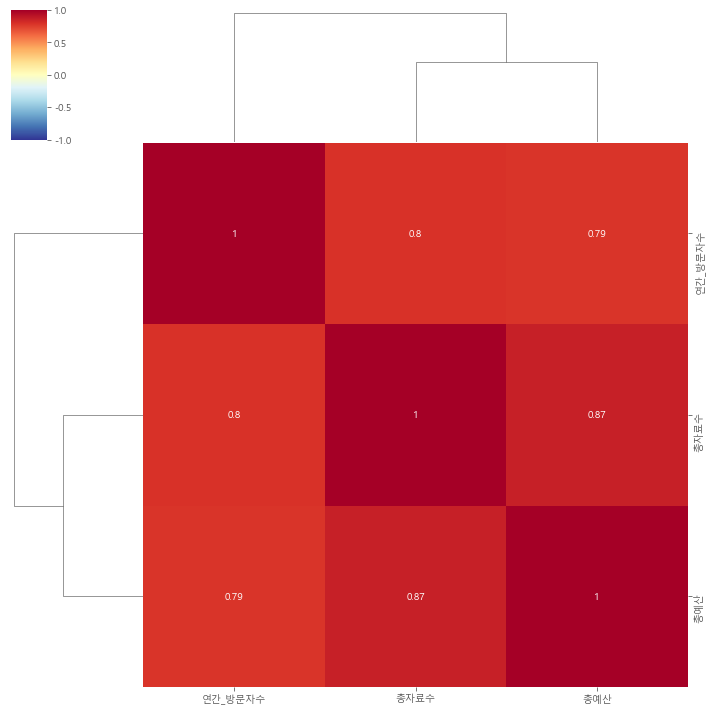

In [204]:
# .fillna()로 NaN을 0으로 바꿔줌
#final = final.fillna(0)
# .corr()로 final 데이터프레임의 상관계수를 얻는다.

data = final.corr()
# clustermap으로 상관관계를 시각화.
#.corr()로 얻은 상관계수가 1에 가까워질수록 하나가 증가할 때 다른 하나도 증가하는 경향이 나타남
# 상관계수가 -1에 가까워질수록 하나가 증가하면 다른 하나가 감소하는 경향이 나타남
sns.clustermap(data, cmap='RdYlBu_r',annot = True,vmin=-1,vmax=1)
plt.rc('font', size=10, family='Malgun Gothic')
plt.show()
plt.close()

# 7.연령별 관심 분야 시각화

## 데이터 프레임 만들기

In [205]:
book_rental=pd.DataFrame()
book_rental['총류']=0
book_rental['철학']=0
book_rental['종교']=0
book_rental['사회과학']=0
book_rental['순수과학']=0
book_rental['기술과학']=0
book_rental['예술']=0
book_rental['언어']=0
book_rental['문학']=0
book_rental['역사']=0
book_rental

,총류,철학,종교,사회과학,순수과학,기술과학,예술,언어,문학,역사


## 어린이 데이터 추가

In [206]:
# 대출권수_인쇄자료_어린이_총류 ~ 대출권수_인쇄자료_어린이_역사 열만 데이터 로드
child_raw= pd.read_excel(r'2020년_도서관별통계입력데이터_공공도서관.xlsx', usecols = 'FS,FT,FU,FV,FW,FX,FY,FZ,GA,GB')    
child_raw.head()

,대출권수_인쇄자료_어린이_총류,대출권수_인쇄자료_어린이_철학,대출권수_인쇄자료_어린이_종교,대출권수_인쇄자료_어린이_사회과학,대출권수_인쇄자료_어린이_순수과학,대출권수_인쇄자료_어린이_기술과학,대출권수_인쇄자료_어린이_예술,대출권수_인쇄자료_어린이_언어,대출권수_인쇄자료_어린이_문학,대출권수_인쇄자료_어린이_역사
0,80,27,24,292,397,28,47,126,1121,382
1,11,7,2,66,56,15,9,7,335,48
2,295,133,30,792,704,510,125,69,6462,902
3,372,297,92,895,1239,619,308,156,8868,1057
4,3120,1095,915,8745,10743,2499,806,1815,49659,9274


In [207]:
# 각 행의 값을 더해서 인덱스 '어린이'에 추가
child_raw.loc['어린이',:] = child_raw.sum()
child_raw.tail()

,대출권수_인쇄자료_어린이_총류,대출권수_인쇄자료_어린이_철학,대출권수_인쇄자료_어린이_종교,대출권수_인쇄자료_어린이_사회과학,대출권수_인쇄자료_어린이_순수과학,대출권수_인쇄자료_어린이_기술과학,대출권수_인쇄자료_어린이_예술,대출권수_인쇄자료_어린이_언어,대출권수_인쇄자료_어린이_문학,대출권수_인쇄자료_어린이_역사
1168,155.0,96.0,52.0,486.0,1392.0,213.0,333.0,445.0,4388.0,643.0
1169,291.0,95.0,54.0,548.0,1053.0,262.0,189.0,219.0,3592.0,643.0
1170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1171,43.0,48.0,7.0,221.0,74.0,121.0,56.0,88.0,2504.0,147.0
어린이,620336.0,403230.0,252956.0,1948001.0,2866570.0,745695.0,483711.0,1384548.0,12015011.0,1948362.0


In [208]:
# 컬럼 이름 변경
child_raw.rename(columns = {'대출권수_인쇄자료_어린이_총류' : '총류',
                     '대출권수_인쇄자료_어린이_철학' : '철학',
                     '대출권수_인쇄자료_어린이_종교' : '종교',
                     '대출권수_인쇄자료_어린이_사회과학' : '사회과학',
                     '대출권수_인쇄자료_어린이_순수과학' : '순수과학',
                     '대출권수_인쇄자료_어린이_기술과학' : '기술과학',
                     '대출권수_인쇄자료_어린이_예술' : '예술',
                     '대출권수_인쇄자료_어린이_언어' : '언어',
                     '대출권수_인쇄자료_어린이_문학' : '문학',
                     '대출권수_인쇄자료_어린이_역사' : '역사',
                    }, inplace=True)
# 데이터 프레임 'book_rental'에 어린이 추가
book_rental.loc['어린이']=child_raw.loc['어린이']
book_rental

,총류,철학,종교,사회과학,순수과학,기술과학,예술,언어,문학,역사
어린이,620336.0,403230.0,252956.0,1948001.0,2866570.0,745695.0,483711.0,1384548.0,12015011.0,1948362.0


## 청소년 데이터 추가

In [209]:
# 대출권수_인쇄자료_청소년_총류 ~ 대출권수_인쇄자료_청소년_역사 열만 데이터 로드
adolescent_raw= pd.read_excel(r'2020년_도서관별통계입력데이터_공공도서관.xlsx', usecols = 'GC,GD,GE,GF,GG,GH,GI,GJ,GK,GL')
adolescent_raw.head()

,대출권수_인쇄자료_청소년_총류,대출권수_인쇄자료_청소년_철학,대출권수_인쇄자료_청소년_종교,대출권수_인쇄자료_청소년_사회과학,대출권수_인쇄자료_청소년_순수과학,대출권수_인쇄자료_청소년_기술과학,대출권수_인쇄자료_청소년_예술,대출권수_인쇄자료_청소년_언어,대출권수_인쇄자료_청소년_문학,대출권수_인쇄자료_청소년_역사
0,26,16,19,68,87,22,12,14,310,124
1,3,8,0,42,0,0,0,2,121,16
2,84,62,5,173,127,123,22,27,1152,249
3,56,81,4,184,169,117,40,12,1058,168
4,142,1349,67,973,264,451,155,89,1812,312


In [210]:
# 각 행의 값을 더해서 인덱스 '청소년'에 추가
adolescent_raw.loc['청소년',:] = adolescent_raw.sum()

# 컴럼 이름 변경하고 데이터 프레임 'book_rental에 청소년 추가
adolescent_raw.rename(columns = {'대출권수_인쇄자료_청소년_총류' : '총류',
                     '대출권수_인쇄자료_청소년_철학' : '철학',
                     '대출권수_인쇄자료_청소년_종교' : '종교',
                     '대출권수_인쇄자료_청소년_사회과학' : '사회과학',
                     '대출권수_인쇄자료_청소년_순수과학' : '순수과학',
                     '대출권수_인쇄자료_청소년_기술과학' : '기술과학',
                     '대출권수_인쇄자료_청소년_예술' : '예술',
                     '대출권수_인쇄자료_청소년_언어' : '언어',
                     '대출권수_인쇄자료_청소년_문학' : '문학',
                     '대출권수_인쇄자료_청소년_역사' : '역사',
                    }, inplace=True)
book_rental.loc['청소년']=adolescent_raw.loc['청소년']
book_rental.head()

,총류,철학,종교,사회과학,순수과학,기술과학,예술,언어,문학,역사
어린이,620336.0,403230.0,252956.0,1948001.0,2866570.0,745695.0,483711.0,1384548.0,12015011.0,1948362.0
청소년,165474.0,195981.0,82165.0,594195.0,576740.0,297761.0,168883.0,197259.0,2470553.0,411972.0


## 성인 데이터 추가

In [211]:
# 대출권수_인쇄자료_성인_총류 ~ 대출권수_인쇄자료_성인_역사 열만 데이터 로드
adult_raw= pd.read_excel(r'2020년_도서관별통계입력데이터_공공도서관.xlsx', usecols = 'GM,GN,GO,GP,GQ,GR,GS,GT,GU,GV')
adult_raw.head()

,대출권수_인쇄자료_성인_총류,대출권수_인쇄자료_성인_철학,대출권수_인쇄자료_성인_종교,대출권수_인쇄자료_성인_사회과학,대출권수_인쇄자료_성인_순수과학,대출권수_인쇄자료_성인_기술과학,대출권수_인쇄자료_성인_예술,대출권수_인쇄자료_성인_언어,대출권수_인쇄자료_성인_문학,대출권수_인쇄자료_성인_역사
0,254,381,160,1089,557,332,190,303,3003,829
1,42,50,14,235,10,59,15,23,326,28
2,1047,1075,214,3809,1674,2359,512,257,17880,2545
3,1448,1886,438,5109,2969,3261,1657,582,24243,2754
4,1359,1517,492,6942,1675,4153,1221,821,14934,2053


In [212]:
# 각 행의 값을 더해서 인덱스 '성인'에 추가
adult_raw.loc['성인',:] = adult_raw.sum()
# 컴럼 이름 변경하고 데이터 프레임 'book_rental에 청소년 추가
adult_raw.rename(columns = {'대출권수_인쇄자료_성인_총류' : '총류',
                     '대출권수_인쇄자료_성인_철학' : '철학',
                     '대출권수_인쇄자료_성인_종교' : '종교',
                     '대출권수_인쇄자료_성인_사회과학' : '사회과학',
                     '대출권수_인쇄자료_성인_순수과학' : '순수과학',
                     '대출권수_인쇄자료_성인_기술과학' : '기술과학',
                     '대출권수_인쇄자료_성인_예술' : '예술',
                     '대출권수_인쇄자료_성인_언어' : '언어',
                     '대출권수_인쇄자료_성인_문학' : '문학',
                     '대출권수_인쇄자료_성인_역사' : '역사',
                    }, inplace=True)
book_rental.loc['성인']=adult_raw.loc['성인']
book_rental.head()

,총류,철학,종교,사회과학,순수과학,기술과학,예술,언어,문학,역사
어린이,620336.0,403230.0,252956.0,1948001.0,2866570.0,745695.0,483711.0,1384548.0,12015011.0,1948362.0
청소년,165474.0,195981.0,82165.0,594195.0,576740.0,297761.0,168883.0,197259.0,2470553.0,411972.0
성인,1864304.0,2357667.0,836023.0,31973560.0,4434079.0,3595843.0,1779473.0,2469419.0,26001088.0,14585586.0


In [213]:
# 합계 추가
book_rental['합계'] = np.sum(book_rental, axis=1)
book_rental.head()

,총류,철학,종교,사회과학,순수과학,기술과학,예술,언어,문학,역사,합계
어린이,620336.0,403230.0,252956.0,1948001.0,2866570.0,745695.0,483711.0,1384548.0,12015011.0,1948362.0,22668420.0
청소년,165474.0,195981.0,82165.0,594195.0,576740.0,297761.0,168883.0,197259.0,2470553.0,411972.0,5160983.0
성인,1864304.0,2357667.0,836023.0,31973560.0,4434079.0,3595843.0,1779473.0,2469419.0,26001088.0,14585586.0,89897042.0


In [214]:
# 어린이, 청소년, 성인의 수가 달라서 각 장르별 대출 권수를 백분율로 바꿔줌
book_rental['총류']=book_rental['총류']/book_rental['합계']*100
book_rental['철학']=book_rental['철학']/book_rental['합계']*100
book_rental['종교']=book_rental['종교']/book_rental['합계']*100
book_rental['사회과학']=book_rental['사회과학']/book_rental['합계']*100
book_rental['순수과학']=book_rental['순수과학']/book_rental['합계']*100
book_rental['기술과학']=book_rental['기술과학']/book_rental['합계']*100
book_rental['예술']=book_rental['예술']/book_rental['합계']*100
book_rental['언어']=book_rental['언어']/book_rental['합계']*100
book_rental['문학']=book_rental['문학']/book_rental['합계']*100
book_rental['역사']=book_rental['역사']/book_rental['합계']*100

# 합계 컬럼 삭제
del book_rental['합계']
book_rental=book_rental.T
book_rental

,어린이,청소년,성인
총류,2.736565,3.206250,2.073821
철학,1.778818,3.797358,2.622630
종교,1.115896,1.592042,0.929978
사회과학,8.593457,11.513214,35.566865
순수과학,12.645654,11.175003,4.932397
기술과학,3.289576,5.769463,3.999957
예술,2.133854,3.272303,1.979457
언어,6.107828,3.822121,2.746941
문학,53.003302,47.869815,28.923185
역사,8.595050,7.982433,16.224767


## 시각화

## 어린이

In [215]:
plt.style.use('default') 
# 한글 폰트가 깨지지 않게 하기 위해 폰트 경로를 직접 입력
font_path = "c:\Windows\Fonts\MALGUNSL.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

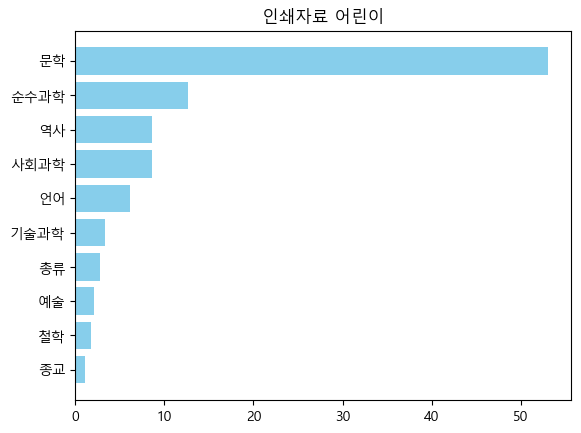

In [216]:
# 장르(분야)가 10개이므로 0, 1, ...,10 위치를 기준으로 삼음
index = np.arange(10)

# 정렬한 인덱스 저장
genre=book_rental['어린이'].sort_values().index

# 내림차순으로 정렬하여 막대그래프 그리기
plt.barh(index, book_rental['어린이'].sort_values(), color='skyblue')

# y축 위치 조정, y축 텍스트를 genre 정보와 매칭
plt.yticks(np.arange(10), genre)

plt.title('인쇄자료 어린이')
plt.show()

## 청소년

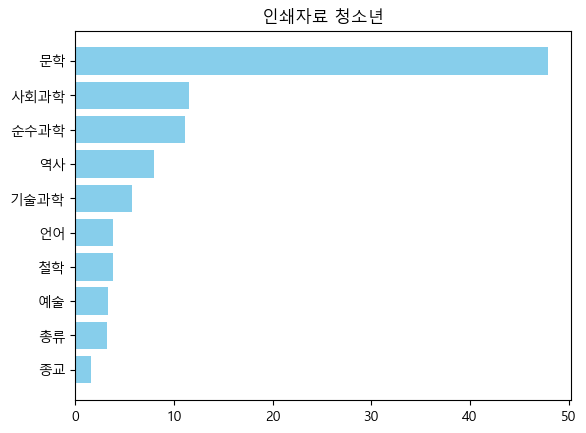

In [217]:
# 장르(분야)가 10개이므로 0, 1, ...,10 위치를 기준으로 삼음
index = np.arange(10)

# 정렬한 인덱스 저장
genre=book_rental['청소년'].sort_values().index

# 내림차순으로 정렬하여 막대그래프 그리기
plt.barh(index, book_rental['청소년'].sort_values(), color='skyblue')

# y축 위치 조정, y축 텍스트를 genre 정보와 매칭
plt.yticks(np.arange(10), genre)

plt.title('인쇄자료 청소년')
plt.show()

## 성인

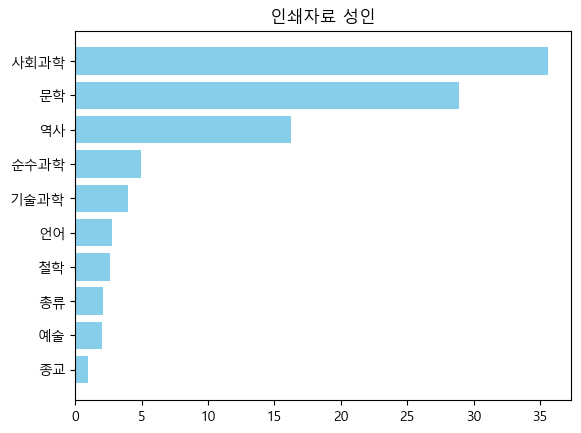

In [218]:
# 장르(분야)가 10개이므로 0, 1, ...,10 위치를 기준으로 삼음
index = np.arange(10)

# 정렬한 인덱스 저장
genre=book_rental['성인'].sort_values().index

# 내림차순으로 정렬하여 막대그래프 그리기
plt.barh(index,book_rental['성인'].sort_values(), color='skyblue')

# y축 위치 조정, y축 텍스트를 genre 정보와 매칭
plt.yticks(np.arange(10), genre)

plt.title('인쇄자료 성인')
plt.show()

## 어린이, 청소년, 성인 비교

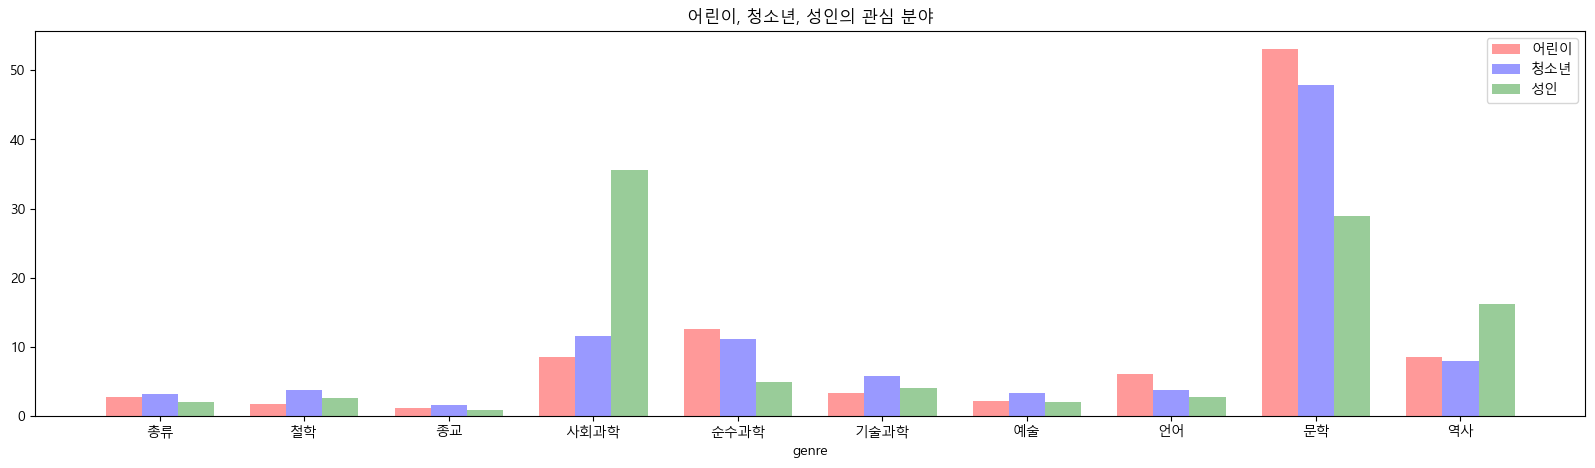

In [219]:
# 그림 사이즈, 바 굵기 조정
fig, ax = plt.subplots(figsize=(20,5))
bar_width = 0.25

genre=['총류', '철학', '종교', '사회과학', '순수과학', '기술과학', '예술', '언어', '문학', '역사']

# 기준으로 삼을 위치
index = np.arange(10)

# 각 장르별로 3개 샵의 bar를 순서대로 나타냄, 각 그래프는 0.25의 간격을 두고 그려짐
b1 = plt.bar(index, book_rental['어린이'], bar_width, alpha=0.4, color='red', label='어린이')
b2 = plt.bar(index + bar_width, book_rental['청소년'], bar_width, alpha=0.4, color='blue', label='청소년')
b3 = plt.bar(index + 2 * bar_width, book_rental['성인'], bar_width, alpha=0.4, color='green', label='성인')

#  x축 위치를 정 가운데로 조정하고 x축의 텍스트를 genre 정보와 매칭
plt.xticks(np.arange(bar_width, 10 + bar_width, 1), genre)

# 축 이름, 범례, 이름 설정
plt.legend()
plt.xlabel('genre', size = 10)
plt.title('어린이, 청소년, 성인의 관심 분야')
plt.show()

# 8. 대출권수 상관 분석

## 순수과학 대출권수와 기술과학 대출권수의 상관 분석

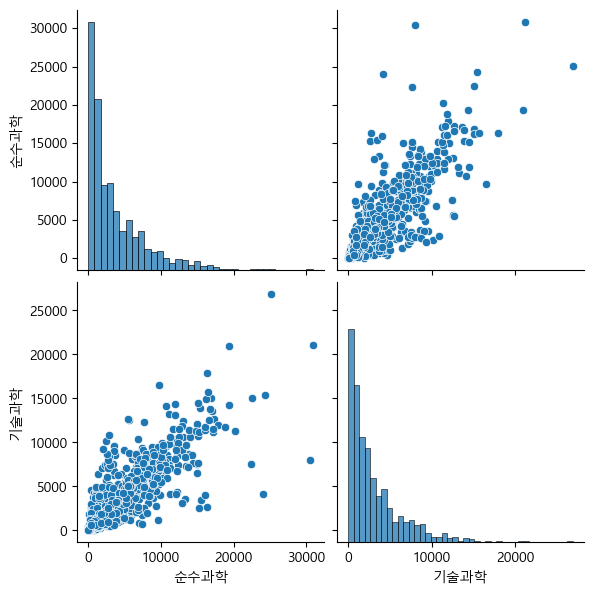

In [222]:
adult = adult_raw.drop('성인',axis=0)
sns.pairplot(adult, vars=["순수과학","기술과학"], height=3)
plt.show()

## 언어 대출권수와 문학 대출권수의 상관 분석

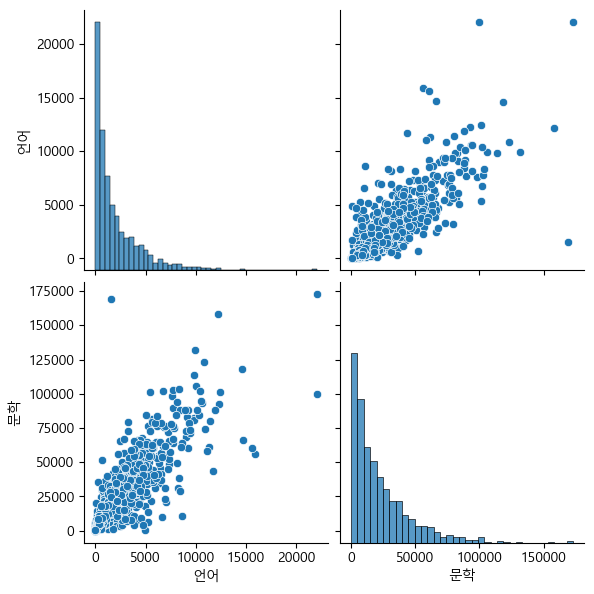

In [223]:
sns.pairplot(adult, vars=["언어","문학"], height=3)
plt.show()